In [2]:
import os
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# ------------------------------------------------------------
# CONFIGURACIÓ D’ENTORN I LLIBRERIES
# ------------------------------------------------------------

# Defineix el directori base i el nom del fitxer
BASE_PATH = r"C:\Users\jesus\Desktop\TFG\GitHUb\TFG_PredictStock\Conjunt de dades Preprocessades\Datasets"
file_name = "Google_Stock_Price_output.csv"
file_path = os.path.join(BASE_PATH, file_name)

# Llegeix el CSV i prepara el DataFrame
df = pd.read_csv(file_path)
df['Date'] = pd.to_datetime(df['Date'], dayfirst=False)
df.sort_values('Date', inplace=True)
df.reset_index(drop=True, inplace=True)

# ------------------------------------------------------------
# 1. FEATURE ENGINEERING
# ------------------------------------------------------------

# 1.1. Features originals (ja precomputats: indicadors tècnics)
base_features = [
    'Open', 'High', 'Low', 'Volume',
    'EMA_7', 'EMA_40', 'MACD', 'Signal_Line',
    'MACD_Hist', 'RSI', 'ATR'
]

# ------------------------------------------------------------
# 2. PREPARACIÓ DE DADES: DIVISIÓ EN TRAIN / VAL / TEST
# ------------------------------------------------------------

# X conté les columnes d'entrada; y el target a 10 dies
X = df[base_features]
y = df['Close']

# Dividim sense barrejament (shuffle=False) per respectar l’ordre temporal
# 70% entrenament, 15% validació, 15% test
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, shuffle=False
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, shuffle=False
)

# ------------------------------------------------------------
# 3. ESCALAT DE FEATURES
# ------------------------------------------------------------

# Escalem mitjançant StandardScaler per posar totes les variables a mitjana 0, desviació típica 1
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)
X_test_scaled  = scaler.transform(X_test)

# ------------------------------------------------------------
# 4. MODELATGE: REGRESSIÓ LINEAL AMB REGULARITZACIÓ (RIDGE)
# ------------------------------------------------------------

# 4.1. Definim un grid de valors alpha per fer GridSearchCV
param_grid = {
    'alpha': [0.01, 0.1, 1.0, 10.0, 100.0]
}

# Fem time-series cross-validation (5 splits) per evitar “leak” temporal
tscv = TimeSeriesSplit(n_splits=5)

ridge = Ridge()
grid_search = GridSearchCV(
    ridge,
    param_grid=param_grid,
    cv=tscv,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

# 4.2. Entrenem el model sobre el conjunt d’entrenament
grid_search.fit(X_train_scaled, y_train)
best_model = grid_search.best_estimator_

print("Millor alpha (Ridge):", grid_search.best_params_['alpha'])

# ------------------------------------------------------------
# 5. AVALUACIÓ DEL MODEL
# ------------------------------------------------------------

def evaluate(model, X, y, subset_name="Subset"):
    """
    Calcula i mostra MSE, MAE, i R^2 per un model entrenat i un conjunt X, y.
    """
    preds = model.predict(X)
    mse = mean_squared_error(y, preds)
    mae = mean_absolute_error(y, preds)
    r2  = r2_score(y, preds)
    print(f"{subset_name} → MSE: {mse:.4f} | MAE: {mae:.4f} | R²: {r2:.4f}")
    return preds

print("\n--- AVALUACIÓ EN VALIDATION SET ---")
preds_val = evaluate(best_model, X_val_scaled, y_val, subset_name="Validation")

print("\n--- AVALUACIÓ EN TEST SET ---")
preds_test = evaluate(best_model, X_test_scaled, y_test, subset_name="Test")


Millor alpha (Ridge): 0.01

--- AVALUACIÓ EN VALIDATION SET ---
Validation → MSE: 0.3325 | MAE: 0.4585 | R²: 0.9955

--- AVALUACIÓ EN TEST SET ---
Test → MSE: 1.0038 | MAE: 0.7412 | R²: 0.9932


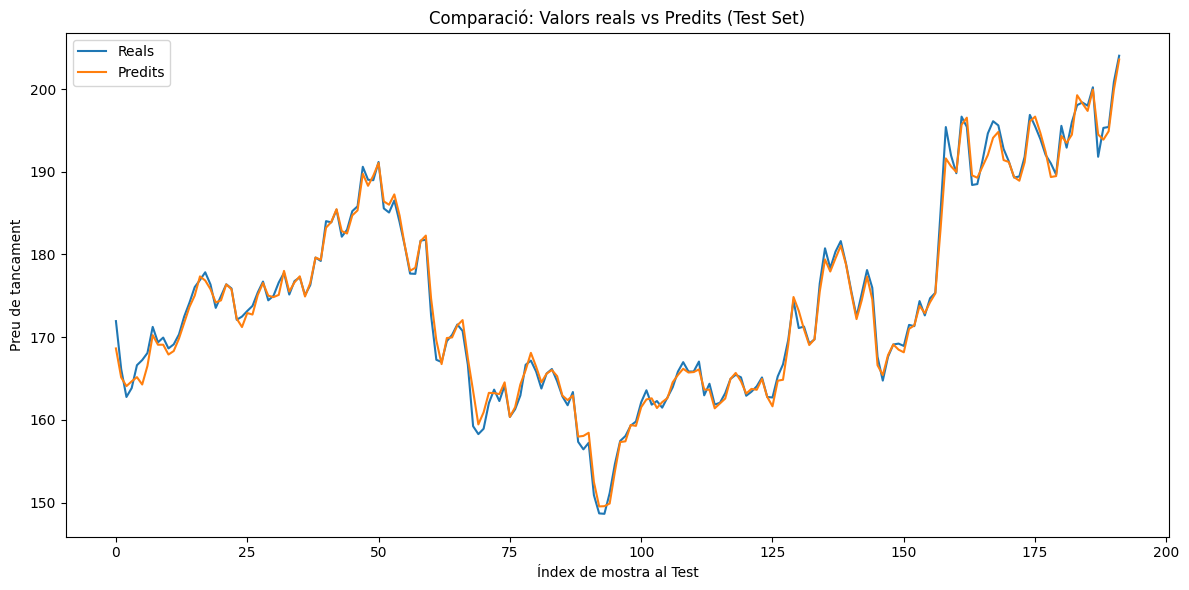

In [3]:
import matplotlib.pyplot as plt

# Suposem que ja tens:
#   y_test       → Pandas Series (o array) amb els valors reals del test
#   y_pred_test  → array (o Series) amb les prediccions del model

plt.figure(figsize=(12, 6))

# Si y_test té índex temporal, vols realment comparar per índex seqüencial:
y_vals = y_test.reset_index(drop=True).values

plt.plot(y_vals, label='Reals', linewidth=1.5)
plt.plot(preds_test, label='Predits', linewidth=1.5)

plt.title('Comparació: Valors reals vs Predits (Test Set)')
plt.xlabel('Índex de mostra al Test')
plt.ylabel('Preu de tancament')
plt.legend()
plt.tight_layout()
plt.show()
